In [23]:
import json
import networkx as nx
import pickle
import gzip
import os
import scipy as sp
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
## evaluation in terms of distances
## taken from https://github.com/afshinrahimi/geographconv
from haversine import haversine
import logging
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)

def geo_eval(y_true, y_pred, U_eval, classLatMedian, classLonMedian, userLocation): 
    assert len(y_pred) == len(U_eval), "#preds: %d, #users: %d" %(len(y_pred), len(U_eval))
    distances = []
    latlon_pred = []
    latlon_true = []
    for i in range(0, len(y_pred)):
        user = U_eval[i]
        location = userLocation[user].split(',')
        lat, lon = float(location[0]), float(location[1])
        latlon_true.append([lat, lon])
        prediction = str(y_pred[i])
        lat_pred, lon_pred = classLatMedian[prediction], classLonMedian[prediction]
        latlon_pred.append([lat_pred, lon_pred])  
        distance = haversine((lat, lon), (lat_pred, lon_pred))
        distances.append(distance)

    acc_at_161 = 100 * len([d for d in distances if d < 161]) / float(len(distances))

#     logging.info( "Mean: " + str(int(np.mean(distances))) + " Median: " + str(int(np.median(distances))) + " Acc@161: " + str(int(acc_at_161)))
        
    return np.mean(distances), np.median(distances), acc_at_161, distances, latlon_true, latlon_pred

In [25]:
# address = os.path.abspath(os.path.join(os.getcwd(), 'datasets/cmu/tfidf_win_2_dm_1adj_d2v_0_dump.pkl'))
# address = '/mnt/c/Users/Parham/Google Drive/Parham/dev/rahimi_data_processed'
# address = os.path.abspath(os.path.join(address, 'dev/rahimi_data_processed'))
# address = '/home/parham/snap/odrive-unofficial/2/Google Drive/Parham/data/world/processed_data'

# filenames = os.listdir(address)
address = '/home/parham/gdrive/rt_Parham/deep_geolocation/datasets/cmu/tfidf_win_2_dm_1adj_d2v_0_dump.pkl'
i = 'tfidf_win_2_dm_1adj_d2v_0_dump'
with gzip.open(address, 'rb') as pickle_file:
    exec(i  + "= pickle.load(pickle_file,encoding='iso-8859-1')")
# for i in filenames:    
#     try:
#         with gzip.open(address +'/'+ i, 'rb') as pickle_file:
#             exec(i  + "= pickle.load(pickle_file,encoding='iso-8859-1')")
#     except:
#         pass

In [26]:
adj, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, U_train, U_dev, U_test, classLatMedian, classLonMedian,userLocation, w_adj_s, edges, total_users =tfidf_win_2_dm_1adj_d2v_0_dump 


In [27]:
def report(address):
    prediction_table = pd.DataFrame(columns =['file_name','arch','dropout','mean', 'median', 'acc'] )
    i = 0
    for file in glob(address + '/*.npy'):
        print(file)
        with open(file,'rb') as f:
            npy = np.load(f)
            mean, median, acc, distances, latlon_true, latlon_pred = geo_eval(Y_test, npy, U_test, classLatMedian, classLonMedian, userLocation)
            prediction_table.loc[i,'file_name'] = file.split('/')[-1] 
            
            arch = []
            for item in prediction_table.loc[i,'file_name'].split('_')[-3]:
                if item.isdigit()==False and item!='.':
                    arch.append(item)
                    
            arch_name = ''.join(map(str, arch))
            if arch_name == 'mean':
                arch_name = 'Mean'
            elif arch_name == 'seq':
                arch_name = 'LSTM'
            else: 
                arch_name = 'Max Pool'
            prediction_table.loc[i,'arch'] = arch_name
            
            prediction_table.loc[i,'dropout'] = float(prediction_table.loc[i,'file_name'].split('_')[-1][:-4])

            prediction_table.loc[i,'mean'] = mean
            prediction_table.loc[i,'median'] = median
            prediction_table.loc[i,'acc'] = acc
            i+=1
    return prediction_table

In [28]:
address_list = ['graphsage_mean_small_0.0100'
                ,'graphsage_meanpool_small_0.0100'
                ,'graphsage_seq_small_0.0100'
               ]
results = []
for address in address_list:
    address = os.getcwd() + '/sup-graphsage_processed_data/' + address
    results.append(report(address))   
    

/home/parham/gdrive/rt_Parham/deep_geolocation/sup-graphsage_processed_data/graphsage_mean_small_0.0100/output_graphsage_mean_cmu_f_0.6_t_1552334630.3024402_d_0.0.npy


In [29]:
address

'/home/parham/gdrive/rt_Parham/deep_geolocation/sup-graphsage_processed_data/graphsage_seq_small_0.0100'

In [30]:
results_pd = pd.concat(results)

In [31]:
results_pd

,file_name,arch,dropout,mean,median,acc
0,output_graphsage_mean_cmu_f_0.6_t_1552334630.3...,Max Pool,0,784.454,272.438,45.1187


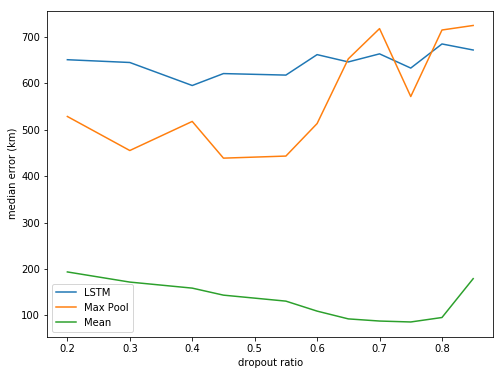

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('median error (km)')
for label, df in results_pd.groupby('arch'):
    df.plot(x='dropout', y = 'median', ax=ax, label = label)
ax.set_xlabel('dropout ratio')

plt.savefig('dropout ratio.png')

### Results interpretation
As the results show, having same number of latent nodes (two 400 node layers) with different GraphSAGE architectures can result in completely different values for median error. This experminet was conducted to capture the effect of dropout ratio on multipe architectures.  

Additionally, the GCN and mean aggregators show superior results, while meanpool and LSTM aggegator performance indicated poor performance both in terms of reliabilty and median error.

In the next step, we hope to compare the performance of each architecture with respect to sample size. Since the mean aggregator had better performance, the performance of mean aggregator over various sample size have been tested.

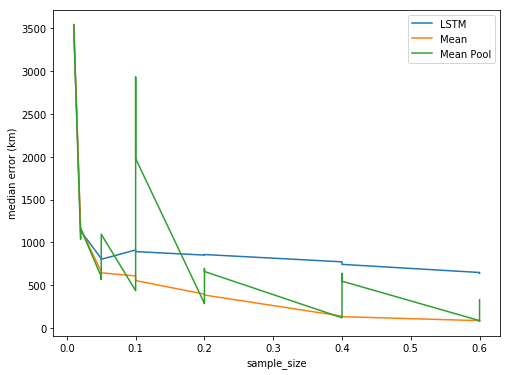

In [10]:
import fnmatch
import os
address = os.path.join(os.getcwd(),'sample_results')
matches = []
for root, dirnames, filenames in os.walk(address):
    matches.append(root)
    
    for filename in fnmatch.filter(filenames, '*'):
        matches.append(os.path.join(root, filename))
results_sample = []
for address in matches:
    df = report(address)
    sample_size = address.split('/')[-2]
    try:
        sample_size = float(sample_size.split('_')[-1])
    except:
        
        pass
    
    df['sample_size'] = sample_size
    results_sample.append(df)
results_sample_pd = pd.concat(results_sample)
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('median error (km)')
for label, df in results_sample_pd.groupby('arch'):
    df.plot(x='sample_size', y = 'median', ax=ax, label = label)